You can run this notebook in a [live session](https://mybinder.org/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/prediction-ensemble-object.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://mybinder.org/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/prediction-ensemble-object.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/prediction-ensemble-object.ipynb).

# PredictionEnsemble Objects

One of the major features of `climpred` is our objects that are based upon the {py:class}`.PredictionEnsemble` class. We supply users with a {py:class}`.HindcastEnsemble` or {py:class}`.PerfectModelEnsemble` object. We encourage users to take advantage of these high-level objects, which wrap all of our core functions.

Briefly, we consider a {py:class}`.HindcastEnsemble` to be one that is initialized from some observational-like product (e.g., assimilated data, reanalysis products, or a model reconstruction). Thus, this object is built around comparing the initialized ensemble to various observational products.
In contrast, a {py:class}`.PerfectModelEnsemble` is one that is initialized off of a model control simulation. These forecasting systems are not meant to be compared directly to real-world observations. Instead, they provide a contained model environment with which to theoretically study the limits of predictability. You can read more about the terminology used in `climpred` [here](terminology.html#Terminology).

Let's create a demo object to explore some of the functionality and why they are much smoother to use than direct function calls.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from climpred import HindcastEnsemble, PerfectModelEnsemble
from climpred.tutorial import load_dataset
import climpred

<IPython.core.display.Javascript object>

We can now pull in some sample data that is packaged with `climpred`. We'll start out with a {py:class}`.HindcastEnsemble` demo, followed by a {py:class}`.PerfectModelEnsemble` case.

## HindcastEnsemble

In [3]:
initialized = climpred.tutorial.load_dataset(
    "CESM-DP-SST"
)  # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset("ERSST")  # ERSST observations.

<IPython.core.display.Javascript object>

We need to add a ``units`` attribute to the hindcast ensemble so that `climpred` knows how to interpret the lead units.

In [4]:
initialized["lead"].attrs["units"] = "years"

<IPython.core.display.Javascript object>

Now we instantiate the {py:class}`.HindcastEnsemble` object and append all of our products to it.

In [5]:
hindcast = HindcastEnsemble(
    initialized
)  # Instantiate object by passing in our initialized ensemble.
hindcast

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (lead: 10, member: 10, init: 64)
Coordinates:
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 * member (member) int32 1 2 3 4 5 6 7 8 9 10
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Data variables:
 SST (init, lead, member) float64 -0.2404 -0.2085 ... 0.7442 0.7384 Initialized Ensemble Dimensions: lead : 10 member : 10 init : 64 Coordinates: (4) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : Lead units : years standard_name : forecast_period description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) member (member) int32 1 2 3 4 5 6 7 8 9 10 long_name : Member standard_name : realization description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0,

<IPython.core.display.Javascript object>

Now we just use {py:meth}`.HindcastEnsemble.add_observations` to attach other objects. See the API [here](api.html#add-and-retrieve-datasets). Note that we strive to make our conventions follow those of [`xarray`](https://xarray.pydata.org/en/stable/). For example, we don't allow inplace operations. One has to run `hindcast = hindcast.add_observations(...)` to modify the object upon later calls rather than just `hindcast.add_observations(...)`.

In [6]:
hindcast = hindcast.add_observations(obs)
hindcast

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (lead: 10, member: 10, init: 64)
Coordinates:
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 * member (member) int32 1 2 3 4 5 6 7 8 9 10
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Data variables:
 SST (init, lead, member) float64 -0.2404 -0.2085 ... 0.7442 0.7384 Initialized Ensemble Dimensions: lead : 10 member : 10 init : 64 Coordinates: (4) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : Lead units : years standard_name : forecast_period description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) member (member) int32 1 2 3 4 5 6 7 8 9 10 long_name : Member standard_name : realization description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0,

<Observations>
Dimensions: (time: 61)
Coordinates:
 * time (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
 SST (time) float32 17.79 17.84 18.0 18.03 ... 18.41 18.44 18.54 18.64 Observations Dimensions: time : 61 Coordinates: (1) time (time) object 1955-01-01 00:00:00 ... 2015-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1990, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1992, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1995, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1996, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1997, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1998, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 1

<IPython.core.display.Javascript object>

You can apply most standard `xarray` functions directly to our objects! `climpred` will loop through the objects and apply the function to all applicable {py:class}`xarray.Dataset` within the object. If you reference a dimension that doesn't exist for the given {py:class}`xarray.Dataset`, it will ignore it. This is useful, since the initialized ensemble is expected to have dimension `init`, while other products have dimension `time` (see more [here](setting-up-data.html#setting-up-your-dataset)).

Let's start by taking the ensemble mean of the initialized ensemble. Just using deterministic [metrics](metrics.html#Metrics) here, so we don't need the individual ensemble members. Note that above our initialized ensemble had a `member` dimension, and now it is reduced. Those `xarray` functions do not raise errors such as `ValueError`, `KeyError`, `DimensionError`, but show respective warnings, which can be filtered away with `warnings.filterwarnings("ignore")`.

In [7]:
hindcast = hindcast.mean("member")
hindcast

/Users/aaron.spring/Coding/climpred/climpred/classes.py:713: UserWarning: Error due to verification/control/uninitialized: xr.mean(('member',), {}) failed
ValueError: Dataset does not contain the dimensions: ['member']
  warnings.warn(


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (lead: 10, init: 64)
Coordinates:
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Data variables:
 SST (init, lead) float64 -0.2121 -0.1637 -0.1206 ... 0.7286 0.7532 Initialized Ensemble Dimensions: lead : 10 init : 64 Coordinates: (3) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : Lead units : years standard_name : forecast_period description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.Datet

<Observations>
Dimensions: (time: 61)
Coordinates:
 * time (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
 SST (time) float32 17.79 17.84 18.0 18.03 ... 18.41 18.44 18.54 18.64 Observations Dimensions: time : 61 Coordinates: (1) time (time) object 1955-01-01 00:00:00 ... 2015-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1990, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1992, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1995, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1996, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1997, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1998, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 1

<IPython.core.display.Javascript object>

### Arithmetic Operations with PredictionEnsemble Objects

{py:class}`.PredictionEnsemble` objects support arithmetic operations, i.e., `+`, `-`, `/`, `*`. You can perform these operations on a {py:class}`.HindcastEnsemble` or {py:class}`.PerfectModelEnsemble` by pairing the operation with an `int`, `float`, `np.ndarray`, {py:class}`xarray.DataArray`, {py:class}`xarray.Dataset`, or with another {py:class}`.PredictionEnsemble` object.

An obvious application would be to area-weight an initialized ensemble and all of its associated datasets simultaneously.

In [8]:
dple3d = climpred.tutorial.load_dataset("CESM-DP-SST-3D")
verif3d = climpred.tutorial.load_dataset("FOSI-SST-3D")
area = dple3d["TAREA"]

<IPython.core.display.Javascript object>

Here, we load in a subset of ``CESM-DPLE`` over the eastern tropical Pacific. The file includes `TAREA`, which describes the area of each cell on the curvilinear mesh.

In [9]:
hindcast3d = HindcastEnsemble(dple3d)
hindcast3d = hindcast3d.add_observations(verif3d)
hindcast3d

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 64, lead: 10, nlat: 37, nlon: 26)
Coordinates:
 TLAT (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336
 TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 276.7 277.8 278.9
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 TAREA (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
 SST (init, lead, nlat, nlon) float32 -0.3323 -0.3238 ... 1.179 1.123 Initialized Ensemble Dimensions: init : 64 lead : 10 nlat : 37 nlon : 26 Coordinates: (6) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 units : degrees_north long_name : array of t-grid latitudes array([[-9.750341, -9.750341, -9.750341, ..., -9.750341, -9.750341, -9.750341],
 [-9.483209, -9.483209, -9.483209, ..., -9.483209, -9.483209, -9.483209],
 [-9.216077, -9.216077, -9.216077, ..., -9.216077, -9.216077, -9.216077],
 ...,
 [-0.667832, -0.667832, -0.667832, ..., -0.667832, -0.667832, -0.667832],
 [-0.400699, -0.400699, -0.400699, ..., -0.400699, -0.400699, -0.400699],
 [-0.133566, -0.133566, -0.133566, ..., -0.133566, -0.133566, -0.133566]]) TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 277.8 278.9 units : degrees_east long_name : array of t-grid longitudes array([[250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 ...,
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508]]) init (init) object 1954-01-01 00:00:00 ... 2017-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_y

<Observations>
Dimensions: (time: 68, nlat: 37, nlon: 26)
Coordinates:
 TLAT (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336 -0.1336
 TLONG (nlat, nlon) float64 250.8 251.9 253.1 254.2 ... 276.7 277.8 278.9
 * time (time) object 1948-01-01 00:00:00 ... 2015-01-01 00:00:00
 TAREA (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
Dimensions without coordinates: nlat, nlon
Data variables:
 SST (time, nlat, nlon) float32 25.53 25.43 25.35 ... 27.03 27.1 27.05 Observations Dimensions: time : 68 nlat : 37 nlon : 26 Coordinates: (4) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 units : degrees_north long_name : array of t-grid latitudes array([[-9.750341, -9.750341, -9.750341, ..., -9.750341, -9.750341, -9.750341],
 [-9.483209, -9.483209, -9.483209, ..., -9.483209, -9.483209, -9.483209],
 [-9.216077, -9.216077, -9.216077, ..., -9.216077, -9.216077, -9.216077],
 ...,
 [-0.667832, -0.667832, -0.667832, ..., -0.667832, -0.667832, -0.667832],
 [-0.400699, -0.400699, -0.400699, ..., -0.400699, -0.400699, -0.400699],
 [-0.133566, -0.133566, -0.133566, ..., -0.133566, -0.133566, -0.133566]]) TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 277.8 278.9 units : degrees_east long_name : array of t-grid longitudes array([[250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 ...,
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508]]) time (time) object 1948-01-01 00:00:00 ... 2015-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1948, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1949, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1951, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1952, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1953, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_

<IPython.core.display.Javascript object>

Now we can perform an area-weighting operation with the `HindcastEnsemble` object and the area {py:class}`xarray.DataArray`. `climpred` cycles through all of the datasets appended to the {py:class}`.HindcastEnsemble` and applies them. You can see below that the dimensionality is reduced to single time series without spatial information.

In [10]:
hindcast3d_aw = (hindcast3d * area).sum(["nlat", "nlon"]) / area.sum(["nlat", "nlon"])
hindcast3d_aw

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 64, lead: 10)
Coordinates:
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Data variables:
 SST (init, lead) float64 -0.3539 0.1947 0.3623 ... 0.662 1.016 1.249 Initialized Ensemble Dimensions: init : 64 lead : 10 Coordinates: (3) init (init) object 1954-01-01 00:00:00 ... 2017-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1990, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1992, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGr

<Observations>
Dimensions: (time: 68)
Coordinates:
 * time (time) object 1948-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
 SST (time) float64 24.76 24.48 23.73 24.68 ... 24.78 24.21 24.92 25.95 Observations Dimensions: time : 68 Coordinates: (1) time (time) object 1948-01-01 00:00:00 ... 2015-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1948, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1949, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1951, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1952, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1953, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1990, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1992, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 1, 

<IPython.core.display.Javascript object>

**NOTE**: Be careful with the arithmetic operations. Some of the behavior can be unexpected in combination with the fact that generic `xarray` methods can be applied to `climpred` objects. For instance, one might be interested in removing a climatology from the verification data to move it to anomaly space. It's safest to do anything like climatology removal before constructing `climpred` objects.

Naturally, they would remove some climatology time slice as we do here below. However, note that in the below example, the intialized ensemble returns all zeroes for `SST`. The reasoning here is that when `hindcast.sel(time=...)` is called, `climpred` only applies that slicing to datasets that include the `time` dimension. Thus, it skips the initialized ensemble and returns the original dataset untouched. This feature is advantageous for cases like `hindcast.mean('member')`, where it takes the ensemble mean in all cases that ensemble members exist. So when it performs `hindcast - hindcast.sel(time=...)`, it subtracts the identical initialized ensemble from itself returning all zeroes. 

In short, any sort of bias correcting or drift correction can also be done _prior_ to instantiating a {py:class}`.PredictionEnsemble` object. Alternatively, detrending or removing a mean state can also be done _after_ instantiating a {py:class}`.PredictionEnsemble` object. Also consider {py:meth}`.HindcastEnsemble.remove_bias` and {py:meth}`.HindcastEnsemble.remove_seasonality`. But beware of unintuitive behaviour. Removing a `time` anomaly in {py:class}`.PredictionEnsemble`, does not modify `initialized` and therefore returns all `0`s.

In [11]:
hindcast3d - hindcast3d.sel(time=slice("1960", "2014")).mean("time")

/Users/aaron.spring/Coding/climpred/climpred/classes.py:707: UserWarning: Error due to initialized:  xr.sel((), {'time': slice('1960', '2014', None)}) failed
KeyError: 'time is not a valid dimension or coordinate'
  warnings.warn(f"Error due to initialized:  {msg}")
/Users/aaron.spring/Coding/climpred/climpred/classes.py:707: UserWarning: Error due to initialized:  xr.mean(('time',), {}) failed
ValueError: Dataset does not contain the dimensions: ['time']
  warnings.warn(f"Error due to initialized:  {msg}")


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (nlat: 37, nlon: 26, init: 64, lead: 10)
Coordinates:
 TLAT (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336
 TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 276.7 277.8 278.9
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 TAREA (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
 SST (init, lead, nlat, nlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 Initialized Ensemble Dimensions: nlat : 37 nlon : 26 init : 64 lead : 10 Coordinates: (6) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 units : degrees_north long_name : array of t-grid latitudes array([[-9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113],
 [-9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897],
 [-9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677],
 [-8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
...
 -0.93496507, -0.93496507, -0.93496507, -0.93496507, -0.93496507,
 -0.93496507],
 [-0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 ],
 [-0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932],
 [-0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644]]) TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 277.8 278.9 units : degrees_east long_name : array of t-grid longitudes array([[250.81250698, 251.93750701, 253.06250704, 254.18750707,
 255.3125071 , 256.43750714, 257.56250717, 258.6875072 ,
 259.81250723, 260.93750726, 262.06250729, 263.18750732,
 264.31250736, 265.43750739, 266.56250742, 267.68750745,
 268.81250748, 269.93750751, 271.06250754, 272.18750757,
 273.31250761, 274.43750764, 275.56250767, 276.6875077 ,
 277.81250773, 278.93750776],
 [250.81250698, 251.93750701, 253.06250704, 254.18750707,
 255.3125071 , 256.43750714, 257.56250717, 258.6875072 ,
 259.81250723, 260.93750726, 262.06250729, 263.18750732,
 264.31250736, 265.43750739, 266.56250742, 267.68750745,
 268.81250748, 269.93750751, 271.06250754, 272.18750757,
 273.31250761, 274.43750764, 275.56250767, 276.6875077 ,
 277.81250773, 278.93750776],
 [250.81250

<Observations>
Dimensions: (nlat: 37, nlon: 26, time: 68)
Coordinates:
 TLAT (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336 -0.1336
 TLONG (nlat, nlon) float64 250.8 251.9 253.1 254.2 ... 276.7 277.8 278.9
 * time (time) object 1948-01-01 00:00:00 ... 2015-01-01 00:00:00
 TAREA (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
Dimensions without coordinates: nlat, nlon
Data variables:
 SST (time, nlat, nlon) float32 0.01611 0.01459 0.0161 ... 1.543 1.49 Observations Dimensions: nlat : 37 nlon : 26 time : 68 Coordinates: (4) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 units : degrees_north long_name : array of t-grid latitudes array([[-9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113, -9.75034113, -9.75034113, -9.75034113, -9.75034113,
 -9.75034113],
 [-9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897, -9.48320897, -9.48320897, -9.48320897, -9.48320897,
 -9.48320897],
 [-9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677, -9.21607677, -9.21607677, -9.21607677, -9.21607677,
 -9.21607677],
 [-8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
 -8.94894453, -8.94894453, -8.94894453, -8.94894453, -8.94894453,
...
 -0.93496507, -0.93496507, -0.93496507, -0.93496507, -0.93496507,
 -0.93496507],
 [-0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 , -0.6678322 ,
 -0.6678322 ],
 [-0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932, -0.40069932, -0.40069932, -0.40069932, -0.40069932,
 -0.40069932],
 [-0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644, -0.13356644, -0.13356644, -0.13356644, -0.13356644,
 -0.13356644]]) TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 277.8 278.9 units : degrees_east long_name : array of t-grid longitudes array([[250.81250698, 251.93750701, 253.06250704, 254.18750707,
 255.3125071 , 256.43750714, 257.56250717, 258.6875072 ,
 259.81250723, 260.93750726, 262.06250729, 263.18750732,
 264.31250736, 265.43750739, 266.56250742, 267.68750745,
 268.81250748, 269.93750751, 271.06250754, 272.18750757,
 273.31250761, 274.43750764, 275.56250767, 276.6875077 ,
 277.81250773, 278.93750776],
 [250.81250698, 251.93750701, 253.06250704, 254.18750707,
 255.3125071 , 256.43750714, 257.56250717, 258.6875072 ,
 259.81250723, 260.93750726, 262.06250729, 263.18750732,
 264.31250736, 265.43750739, 266.56250742, 267.68750745,
 268.81250748, 269.93750751, 271.06250754, 272.18750757,
 273.31250761, 274.43750764, 275.56250767, 276.6875077 ,
 277.81250773, 278.93750776],
 [250.81250698, 251.93750701, 253.06250704, 254.18750707,
 255.3125071 , 256.43750714, 257.56250717, 258.6875072 ,
 259.81250723, 260.93750726, 262.062

<IPython.core.display.Javascript object>

To fix this always handle all {py:class}`.PredictionEnsemble` datasets `initialized` with dimensions `lead` or `init` and `observations`/`control` with dimension `time` at the same time to avoid these zeros.

In [12]:
hindcast - hindcast.sel(time=slice("1960", "2014")).mean("time").sel(
    init=slice("1960", "2014")
).mean("init")

/Users/aaron.spring/Coding/climpred/climpred/classes.py:707: UserWarning: Error due to initialized:  xr.sel((), {'time': slice('1960', '2014', None)}) failed
KeyError: 'time is not a valid dimension or coordinate'
  warnings.warn(f"Error due to initialized:  {msg}")
/Users/aaron.spring/Coding/climpred/climpred/classes.py:707: UserWarning: Error due to initialized:  xr.mean(('time',), {}) failed
ValueError: Dataset does not contain the dimensions: ['time']
  warnings.warn(f"Error due to initialized:  {msg}")
/Users/aaron.spring/Coding/climpred/climpred/classes.py:718: UserWarning: xr.sel((), {'init': slice('1960', '2014', None)}) failed
KeyError: 'init is not a valid dimension or coordinate'
  warnings.warn(msg)
/Users/aaron.spring/Coding/climpred/climpred/classes.py:718: UserWarning: xr.mean(('init',), {}) failed
ValueError: Dataset does not contain the dimensions: ['init']
  warnings.warn(msg)


climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (lead: 10, init: 64)
Coordinates:
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 valid_time (lead, init) object 1955-01-01 00:00:00 ... 2027-01-01 00:00:00
Data variables:
 SST (init, lead) float64 -0.2046 -0.1688 -0.1335 ... 0.6326 0.6463 Initialized Ensemble Dimensions: lead : 10 init : 64 Coordinates: (3) lead (lead) int32 1 2 3 4 5 6 7 8 9 10 long_name : Lead units : years standard_name : forecast_period description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=int32) init (init) object 1954-01-01 00:00:00 ... 2017-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.Datet

<Observations>
Dimensions: (time: 61)
Coordinates:
 * time (time) object 1955-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
 SST (time) float32 -0.3864 -0.3373 -0.17 ... 0.2632 0.3611 0.4653 Observations Dimensions: time : 61 Coordinates: (1) time (time) object 1955-01-01 00:00:00 ... 2015-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1990, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1992, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1995, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1996, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1997, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1998, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2000, 1, 1, 0,

<IPython.core.display.Javascript object>

Note: Thinking in initialization space is not very intuitive and such combined `init` and `time` operations can lead to unanticipated changes in the {py:class}`.PredictionEnsemble`. The safest way is subtracting means before instantiating {py:class}`.PredictionEnsemble` or use {py:meth}`.HindcastEnsemble.remove_bias`.

### Visualizing PredictionEnsemble

{py:meth}`.PredictionEnsemble.plot()` showings all datasets associated if only `member`, `init` and `lead` dimensions are present.

<AxesSubplot:xlabel='validity time', ylabel='SST'>

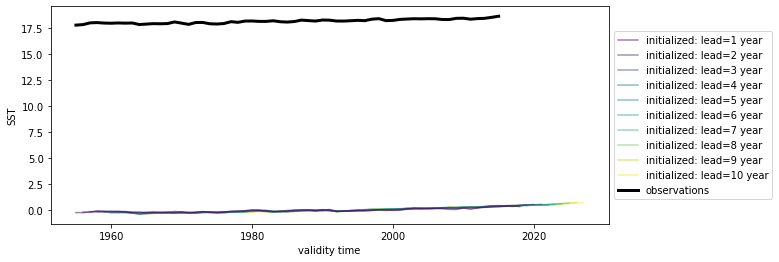

<IPython.core.display.Javascript object>

In [13]:
hindcast.plot()

We have a huge bias because the initialized data is already converted to an anomaly, but `uninitialized` and observations is not. We also have a trend in all of our products, so we could also detrend them as well.

### Detrend

We can leverage `xarray`'s `.map()` function to apply/map a function to all variables in our datasets. We use {py:func}`.climpred.stats.rm_poly` to remove the trend.

<AxesSubplot:xlabel='validity time', ylabel='SST'>

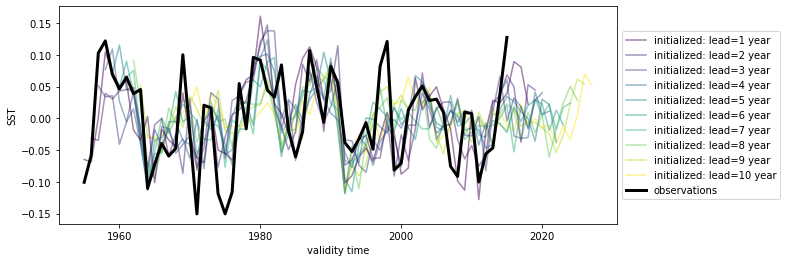

<IPython.core.display.Javascript object>

In [14]:
from climpred.stats import rm_poly

hindcast_detrended = hindcast.map(rm_poly, deg=2, dim="init_or_time")
hindcast_detrended.plot()

And it looks like everything got detrended by a quadratic fit! That wasn't too hard.

### Verify

Now that we've done our pre-processing, let's quickly compute some metrics. Check the [metrics](metrics.html#Metrics) for all the keywords you can use. The [API](api.html#analysis-functions) is currently pretty simple for the {py:class}`.HindcastEnsemble`. You can essentially compute standard skill metrics and [reference forecasts](reference_forecast.html#reference-forecasts), here ``persistence``.

In [15]:
hindcast_detrended.verify(
    metric="mse",
    comparison="e2o",
    dim="init",
    alignment="same_verif",
    reference="persistence",
)

<xarray.Dataset>
Dimensions:  (skill: 2, lead: 10)
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * skill    (skill) <U11 'initialized' 'persistence'
Data variables:
    SST      (skill, lead) float64 0.003274 0.004149 ... 0.01109 0.008786
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     64
    alignment:                     same_verif
    metric:                        mse
    comparison:                    e2o
    dim:                           init
    reference:                     ['persistence']

<IPython.core.display.Javascript object>

Here we leverage `xarray`'s plotting method to compute Mean Absolute Error and the Anomaly Correlation Coefficient against the ERSST observations, as well as the equivalent metrics computed for persistence forecasts for each of those metrics.

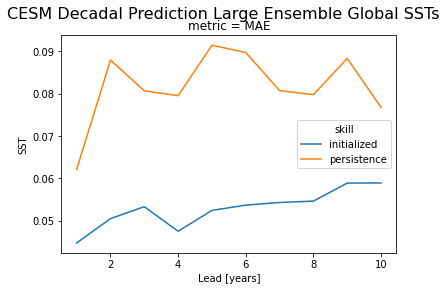

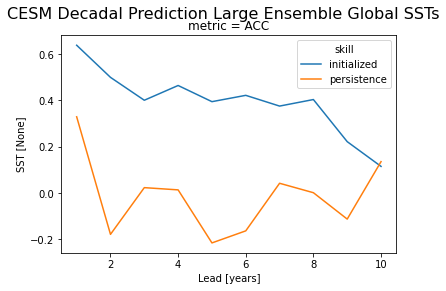

<IPython.core.display.Javascript object>

In [33]:
metrics = ["mae", "acc"]
for metric in metrics:
    hindcast_detrended.verify(
        metric=metric,
        comparison="e2o",
        dim="init",
        alignment="same_verif",
        reference="persistence",
    ).assign_coords(metric=metric.upper()).SST.plot(hue="skill")
    plt.suptitle("CESM Decadal Prediction Large Ensemble Global SSTs", fontsize=16)
    plt.show()

## PerfectModelEnsemble

We'll now play around a bit with the {py:class}`.PerfectModelEnsemble` object, using sample data from the `MPI-ESM` perfect model configuration.

In [17]:
initialized = load_dataset("MPI-PM-DP-1D")  # initialized ensemble from MPI
control = load_dataset("MPI-control-1D")  # base control run that initialized it

initialized["lead"].attrs["units"] = "years"

<IPython.core.display.Javascript object>

In [18]:
pm = climpred.PerfectModelEnsemble(initialized).add_control(control)
pm

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


climpred.PerfectModelEnsemble

<Initialized Ensemble>
Dimensions: (period: 5, lead: 20, area: 3, init: 12, member: 10)
Coordinates:
 * lead (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
 * period (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
 * area (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
 * init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00
 * member (member) int64 0 1 2 3 4 5 6 7 8 9
 valid_time (lead, init) object 3015-01-01 00:00:00 ... 3277-01-01 00:00:00
Data variables:
 tos (period, lead, area, init, member) float32 17.38 17.58 ... 8.955
 sos (period, lead, area, init, member) float32 34.38 34.37 ... 34.59
 AMO (period, lead, area, init, member) float32 0.1675 ... 0.06075 Initialized Ensemble Dimensions: period : 5 lead : 20 area : 3 init : 12 member : 10 Coordinates: (6) lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) period (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym' array(['DJF', 'JJA', 'MAM', 'SON', 'ym'], dtype=object) area (area) object 'global' ... 'North_Atlantic_SPG' array(['global', 'North_Atlantic', 'North_Atlantic_SPG'], dtype=object) init (init) object 3014-01-01 00:00:00 ... 3257-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(3014, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3023, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3045, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3061, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3124, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3139, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3144, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3175, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3178, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3228, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3237, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3257, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) member (member) int64 0 1 2 3 4 5 6 7 8 9 standard_name : realization long_name : Member description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) valid_time (lead, init) object 3015-01-01 00:00:00 ... 3277-01-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(3015, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3024, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3046, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3062, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3125, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3140, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3145, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3176, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3179, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3

<Control Simulation>
Dimensions: (period: 5, time: 300, area: 3)
Coordinates:
 * time (time) object 3000-01-01 00:00:00 ... 3299-01-01 00:00:00
 * period (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
 * area (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
Data variables:
 tos (period, time, area) float32 17.38 8.76 7.321 ... 17.23 10.84 8.346
 sos (period, time, area) float32 34.37 33.5 34.72 ... 34.35 33.38 34.45
 AMO (period, time, area) float32 0.17 0.17 0.17 ... 0.07905 0.07905 Control Simulation Dimensions: period : 5 time : 300 area : 3 Coordinates: (3) time (time) object 3000-01-01 00:00:00 ... 3299-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(3000, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3001, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3002, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(3297, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3298, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3299, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) period (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym' array(['DJF', 'JJA', 'MAM', 'SON', 'ym'], dtype=object) area (area) object 'global' ... 'North_Atlantic_SPG' array(['global', 'North_Atlantic', 'North_Atlantic_SPG'], dtype=object) Data variables: (3) tos (period, time, area) float32 17.38 8.76 7.321 ... 10.84 8.346 array([[[17.382196, 8.759807, 7.320567],
 [17.344793, 8.402126, 7.033539],
 ...,
 [17.406504, 8.515713, 6.448978],
 [17.368383, 8.417525, 6.937928]],

 [[17.159786, 13.499312, 10.919159],
 [17.00704 , 13.742612, 11.459312],
 ...,
 [17.085367, 13.076672, 9.879821],
 [17.125288, 13.465583, 10.465502]],

 ...,

 [[16.988144, 13.185364, 10.20008 ],
 [16.88766 , 13.153466, 9.775887],
 ...,
 [16.989845, 12.697525, 9.045184],
 [16.961275, 13.096062, 9.693774]],

 [[17.301888, 10.906495, 8.973052],
 [17.148916, 10.958404, 8.937663],
 ...,
 [17.221823, 10.586926, 7.862315],
 [17.232193, 10.836343, 8.346231]]], dtype=float32) sos (period, time, area) float32 34.37 33.5 34.72 ... 33.38 34.45 array([[[34.371998, 33.502525, 34.719456],
 [34.355347, 33.519848, 34.671505],
 ...,
 [34.365993, 33.568325, 34.630814],
 [34.355545, 33.500748, 34.479523]],

 [[34.33216 , 33.232624, 34.601894],
 [34.330135, 33.188156, 34.487717],
 ...,
 [34.32915 , 33.16359 , 34.32454 ],
 [34.330036, 33.18352 , 34.319214]],

 ...,

 [[34.33014 , 33.288124, 34.564205],
 [34.326954, 33.26364 , 34.474926],
 ...,
 [34.320232, 33.2581 , 34.364594],
 [34.32564 , 33.225998, 34.278736]],

 [[34.357925, 33.449768, 34.69097 ],
 [34.355095, 33.3701 , 34.60008 ],
 ...,
 [34.35066 , 33.391457, 34.48565 ],
 [34.353535, 33.38208 , 34.451256]]], dtype=float32) AMO (period, time, area) float32 0.17 0.17 0.17 ... 0.07905 0.07905 array([[[ 0.169961, 0.169961, 0.169961],
 [-0.103922, -0.103922, -0.103922],
 ...,
 [ 0.117817, 0.117817, 0.117817],
 [-0.032913, -0.032913, -0.032913]],

 [[ 0.234705, 0.234705, 0.234705],
 [ 0.267132, 0.267132, 0.267132],
 ...,
 [-0.13114 , -0.13114 , -0.13114 ],
 [ 0.036084, 0.036084, 0.036084]],

 ...,

 [[ 0.142128, 0.142128, 0.142128],
 [ 0.087876, 0.087876, 0.087876],
 ...,
 [-0.086413, -0.086413, -0.086413],
 [ 0.151093, 0.151093, 0.151093]],

 [[ 0.167775, 0.167775, 0.167775],
 [ 0.161447, 0.161447, 0.161447],
 ...,
 [-0.02503 , -0.02503 , -0.02503 ],
 [ 0.079047, 0.079047, 0.079047]]], dtype=float32) Attributes: (0)

<IPython.core.display.Javascript object>

Our objects are carrying sea surface temperature (`tos`), sea surface salinity (`sos`), and the Atlantic Multidecadal Oscillation index (`AMO`). Say we just want to look at skill metrics for temperature and salinity over the North Atlantic in JJA. We can just call a few easy `xarray` commands to filter down our object.

In [19]:
pm = pm[["tos", "sos"]].sel(area="North_Atlantic", period="JJA", drop=True)

<IPython.core.display.Javascript object>

Now we can easily compute for a host of metrics. Here I just show a number of deterministic skill metrics comparing all individual members to the initialized ensemble mean. See [comparisons](comparisons.html#comparisons) for more information on the `comparison` keyword.

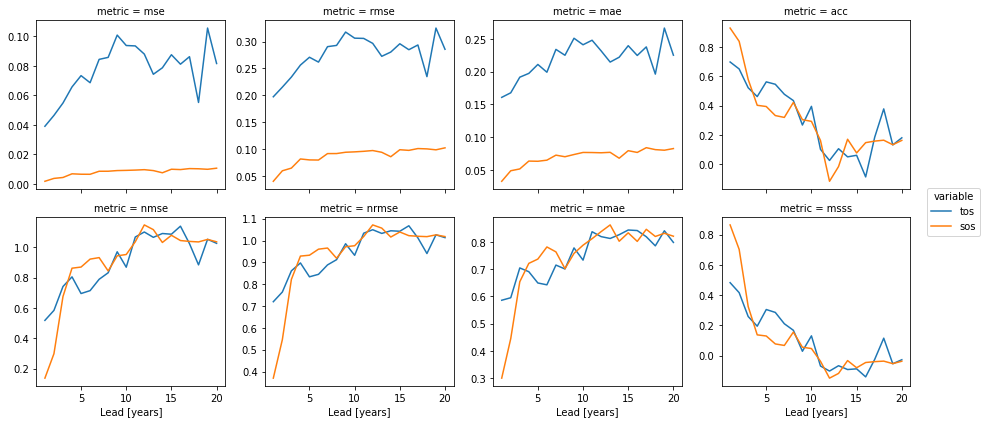

<IPython.core.display.Javascript object>

In [20]:
METRICS = ["mse", "rmse", "mae", "acc", "nmse", "nrmse", "nmae", "msss"]

result = []
for metric in METRICS:
    result.append(pm.verify(metric=metric, comparison="m2e", dim=["init", "member"]))

result = xr.concat(result, "metric")
result["metric"] = METRICS

# Leverage the `xarray` plotting wrapper to plot all results at once.
result.to_array().plot(
    col="metric", hue="variable", col_wrap=4, sharey=False, sharex=True
)

It is useful to compare the initialized ensemble to an uninitialized run. See [terminology](terminology.html#terminology) for a description on `uninitialized` simulations. This gives us information about how initialization leads to enhanced predictability over knowledge of external forcing, whereas a comparison to persistence just tells us how well a dynamical forecast simulation does in comparison to a naive method. We can use the {py:meth}`.PerfectModelEnsemble.generate_uninitialized` to resample the control run and create a pseudo-ensemble that approximates what an uninitialized ensemble would look like.

In [21]:
pm = pm.generate_uninitialized()
pm

climpred.PerfectModelEnsemble

<Initialized Ensemble>
Dimensions: (lead: 20, init: 12, member: 10)
Coordinates:
 * lead (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
 * init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00
 * member (member) int64 0 1 2 3 4 5 6 7 8 9
 valid_time (lead, init) object 3015-01-01 00:00:00 ... 3277-01-01 00:00:00
Data variables:
 tos (lead, init, member) float32 13.46 13.64 13.72 ... 13.55 13.57
 sos (lead, init, member) float32 33.18 33.15 33.05 ... 33.18 33.26 Initialized Ensemble Dimensions: lead : 20 init : 12 member : 10 Coordinates: (4) lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) init (init) object 3014-01-01 00:00:00 ... 3257-01-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(3014, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3023, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3045, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3061, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3124, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3139, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3144, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3175, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3178, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3228, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3237, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3257, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) member (member) int64 0 1 2 3 4 5 6 7 8 9 standard_name : realization long_name : Member description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) valid_time (lead, init) object 3015-01-01 00:00:00 ... 3277-01-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(3015, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3024, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3046, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3062, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3125, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3140, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3145, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3176, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3179, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3229, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3238, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3258, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 [cftime.DatetimeProlepticGregorian(3016, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3025, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3047, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlep

<Control Simulation>
Dimensions: (time: 300)
Coordinates:
 * time (time) object 3000-01-01 00:00:00 ... 3299-01-01 00:00:00
Data variables:
 tos (time) float32 13.5 13.74 13.78 13.86 ... 13.12 12.92 13.08 13.47
 sos (time) float32 33.23 33.19 33.2 33.21 ... 33.15 33.22 33.16 33.18 Control Simulation Dimensions: time : 300 Coordinates: (1) time (time) object 3000-01-01 00:00:00 ... 3299-01-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(3000, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3001, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3002, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(3297, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3298, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3299, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) Data variables: (2) tos (time) float32 13.5 13.74 13.78 ... 13.08 13.47 array([13.499312, 13.742612, 13.783769, ..., 12.917691, 13.076672, 13.465583],
 dtype=float32) sos (time) float32 33.23 33.19 33.2 ... 33.16 33.18 array([33.232624, 33.188156, 33.201694, ..., 33.221058, 33.16359 , 33.18352 ],
 dtype=float32) Attributes: (0)

<Uninitialized>
Dimensions: (lead: 20, init: 12, member: 10)
Coordinates:
 valid_time (lead, init) object 3015-01-01 00:00:00 ... 3277-01-01 00:00:00
 * lead (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
 * init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00
 * member (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
 tos (lead, init, member) float32 13.01 12.84 12.84 ... 13.44 13.57
 sos (lead, init, member) float32 33.08 33.08 33.0 ... 33.16 33.32 Uninitialized Dimensions: lead : 20 init : 12 member : 10 Coordinates: (4) valid_time (lead, init) object 3015-01-01 00:00:00 ... 3277-01-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(3015, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3024, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3046, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3062, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3125, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3140, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3145, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3176, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3179, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3229, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3238, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3258, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 [cftime.DatetimeProlepticGregorian(3016, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3025, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3047, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3063, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3126, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3141, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3146, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3177, 1, 1, 0, 0, 0, 0, has_year_zero=True),
...
 cftime.DatetimeProlepticGregorian(3158, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3163, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3194, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3197, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3247, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3256, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3276, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
 [cftime.DatetimeProlepticGregorian(3034, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3043, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3065, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3081, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3144, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3159, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3164, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3195, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3198, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3248, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3257, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(3277, 1, 1, 0, 0, 0, 0, has_year_zero=True)]],
 dtype=object) lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years standard_name : fore

<IPython.core.display.Javascript object>

In [22]:
pm = pm[["sos"]]  # Just assess for salinity.

<IPython.core.display.Javascript object>

Here we plot the ACC for the ``initialized``, ``uninitialized``, ``climatology`` and ``persistence`` forecasts for North Atlantic sea surface salinity in the JJA summer season.

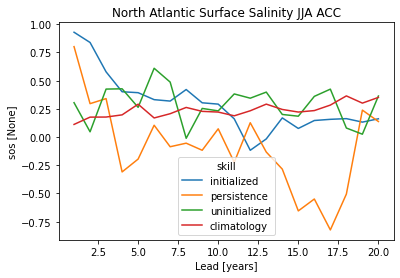

<IPython.core.display.Javascript object>

In [23]:
acc = pm.verify(
    metric="acc",
    comparison="m2e",
    dim=["init", "member"],
    reference=["persistence", "uninitialized", "climatology"],
)
acc.sos.plot(hue="skill")
plt.title("North Atlantic Surface Salinity JJA ACC")
plt.show()